### Imports

In [1]:
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn.functional as F
import umap

from collections import defaultdict
from pathlib import Path
from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from models import *

### Device

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Constants

In [3]:
BATCH_SIZE = 1
INPUT_SIZE = 12
EMBEDDING_SIZE = 384
NUM_EPOCHS = 10
DATA_DIR = Path('../data/dataset/')
LOOKBACK = 2.5
LOWEST_FREQUENCY = 50
KERNEL_SIZE = 3
N_CLUSTERS = 4
SUBSET = ['imu', 'cmd_vel', 'odom']

### Load and split data

In [4]:
with open('../data/labels.json') as fp:
    labels = json.load(fp)
    
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('4W', '6W') and values['spacing'] == 'R1']

X = pd.Series([run[0] for run in dataset], name='bag_name')
y_primary = [run[1] for run in dataset]

y_secondary = ['slippery' if label in ('1_Panele', '5_Spienione_PCV', '6_Linoleum')
               else 'grippy' if label in ('3_Wykladzina_jasna', '8_Pusta_plyta', '9_podklady')
               else 'neutral' for label in y_primary]
# y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
#                else 'grippy' if label in ('5_Spienione_PCV', '8_Pusta_plyta', '9_podklady', '10_Mata_ukladana')
#                else 'neutral' for label in y_primary] # Pawel set
# y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
#                else 'grippy' if label in ('2_Wykladzina_czarna', '5_Spienione_PCV', '9_podklady', '10_Mata_ukladana')
#                else 'neutral' for label in y_primary] # Clustering set

le = LabelEncoder()
le.fit(y_primary)
classes = le.classes_
y = le.transform(y_primary)

### Custom dataset

In [5]:
def select_sequence(series, selected_columns, window_length, stride):
    series = series[selected_columns]
    initial_timestep = random.randint(0, (len(series) - 1) - window_length)
    final_timestep = initial_timestep + window_length
    timesteps = list(range(initial_timestep, final_timestep + stride, stride))
    return series.iloc[timesteps].to_numpy()

In [6]:
class SurfaceDataset(Dataset):
    def __init__(self, samples, labels, frequency=50, lookback=1, subset=None):
        """        
        Args:
            samples: An array of time series, first dimension is time steps
            labels: An array of surface labels
            frequency: The lowest frequency of collected data
            lookback: Size of window for prediction
        """

        self.samples = samples
        self.labels = labels
        self.frequency = frequency
        self.lookback = int(lookback * self.frequency)
        self.stride = int(300 / self.frequency)
        self.window_length = self.lookback * self.stride
        if subset:
            self.subset = set(subset)
        else:
            self.subset = ('cmd_vel', 'imu', 'odom', 'servo')
        measurements = {
            'cmd_vel': ['linear.x', 'angular.z'],
            'imu': ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z'],
            'odom': ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z'],
            'servo': ['values'],
        }
        self.selected_columns = []
        for measurement in self.subset:
            self.selected_columns.extend(measurements[measurement])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single, windowed time series from dataset
        """

        sample = self.samples[idx]
        run = pd.read_csv(sample, index_col=[0]).drop('Time', axis=1)
        
        X = select_sequence(run, self.selected_columns, self.window_length, self.stride)
        y = self.labels[idx]
        
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)
    
dataloader = DataLoader(SurfaceDataset(X, y, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE, shuffle=False)

### Model

In [7]:
cnn_model = CNNSurfaceClassifier(input_size=INPUT_SIZE, output_size=EMBEDDING_SIZE, kernel_size=KERNEL_SIZE).to(device)

In [8]:
cnn_model

CNNSurfaceClassifier(
  (conv_pre): Sequential(
    (0): Conv1d(12, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, tra

### Load checkpoint

In [9]:
checkpoint = torch.load("../data/checkpoints/cnn_classifier_10.pt")
del checkpoint['model_state_dict']['fc_post.2.weight'], checkpoint['model_state_dict']['fc_post.2.bias']
del checkpoint['model_state_dict']['classification.0.weight'], checkpoint['model_state_dict']['classification.0.bias']
cnn_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Embedding

In [29]:
batches = len(dataloader)
embeddings = []

pbar = tqdm(dataloader, total=batches)
cnn_model.eval()
with torch.no_grad():
    for idx, (batch_x, _) in enumerate(pbar):
        batch_x = batch_x.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        embeddings.append(F.normalize(cnn_model(batch_x)).cpu().numpy().squeeze())
embeddings = np.array(embeddings)

100%|██████████| 1339/1339 [00:34<00:00, 38.35it/s]


### Clustering

In [37]:
kmeans = SpectralClustering(n_clusters=10).fit(embeddings)
y_c = kmeans.labels_
classes_c = np.unique(y_c)

### Visualization

Text(0.5, 1.0, 'UMAP projection of the surface embeddings')

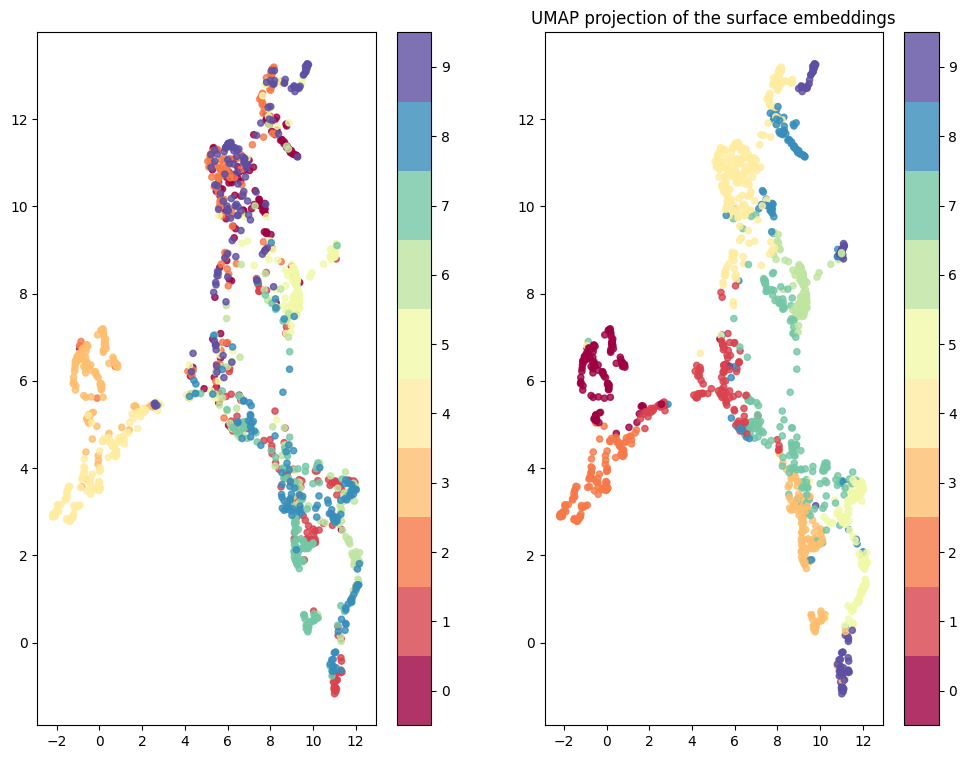

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 9))
reducer = umap.UMAP(random_state=226313, n_jobs=1)
reducer.fit(embeddings)
embedding = reducer.transform(embeddings)
sct = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=20, alpha=0.8)
sct_c = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=y_c, cmap='Spectral', s=20, alpha=0.8)
cbar = fig.colorbar(sct, ticks=np.arange(len(classes)), boundaries=np.arange(len(classes) + 1) - 0.5, ax=axes[0])
cbar_c = fig.colorbar(sct_c, ticks=np.arange(len(classes_c)), boundaries=np.arange(len(classes_c) + 1) - 0.5, ax=axes[1])
# axes[0].set_aspect('equal', 'datalim')
# axes[1].set_aspect('equal', 'datalim')
plt.title('UMAP projection of the surface embeddings', fontsize=12)

In [39]:
metrics.adjusted_rand_score(y, y_c)

0.33335170834703826

In [40]:
metrics.adjusted_mutual_info_score(y, y_c)

0.4723177157130195

In [41]:
metrics.homogeneity_completeness_v_measure(y, y_c)

(0.47334691031465903, 0.4857495324034832, 0.47946802867571475)

In [44]:
metrics.silhouette_score(embeddings, y_c, metric='cosine')

0.29949784

In [43]:
metrics.davies_bouldin_score(embeddings, y_c)

1.7268001561061592

For n_clusters = 2 The average silhouette_score is : 0.5418122
For n_clusters = 3 The average silhouette_score is : 0.47210753
For n_clusters = 4 The average silhouette_score is : 0.4380433
For n_clusters = 5 The average silhouette_score is : 0.36244676
For n_clusters = 6 The average silhouette_score is : 0.40191993
For n_clusters = 7 The average silhouette_score is : 0.37865818
For n_clusters = 8 The average silhouette_score is : 0.38011846
For n_clusters = 9 The average silhouette_score is : 0.35855246
For n_clusters = 10 The average silhouette_score is : 0.32984126


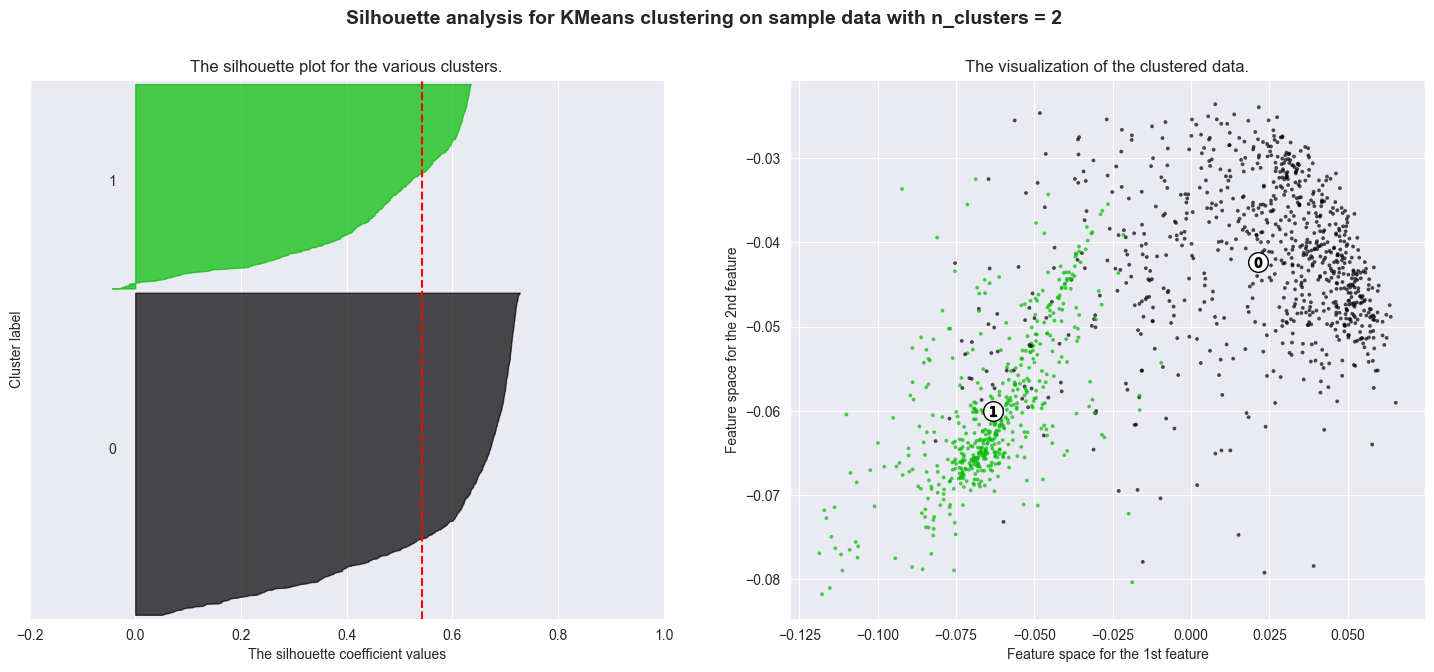

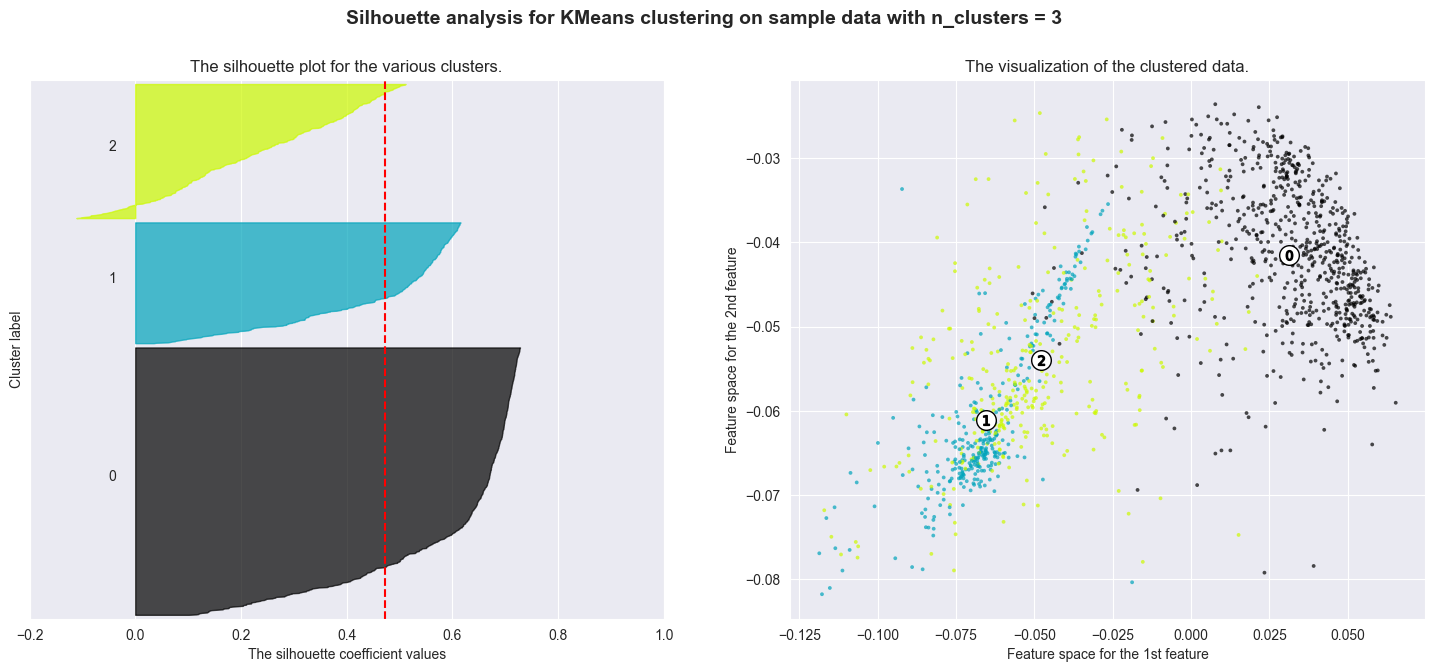

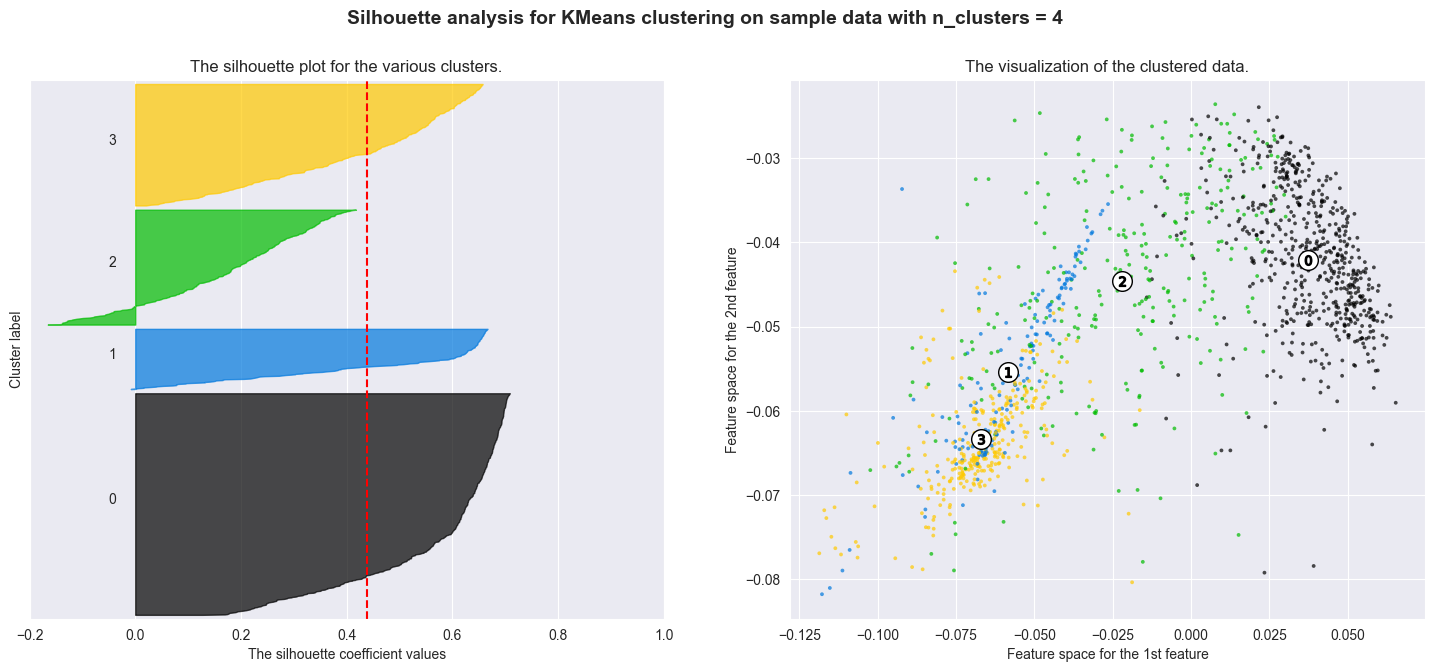

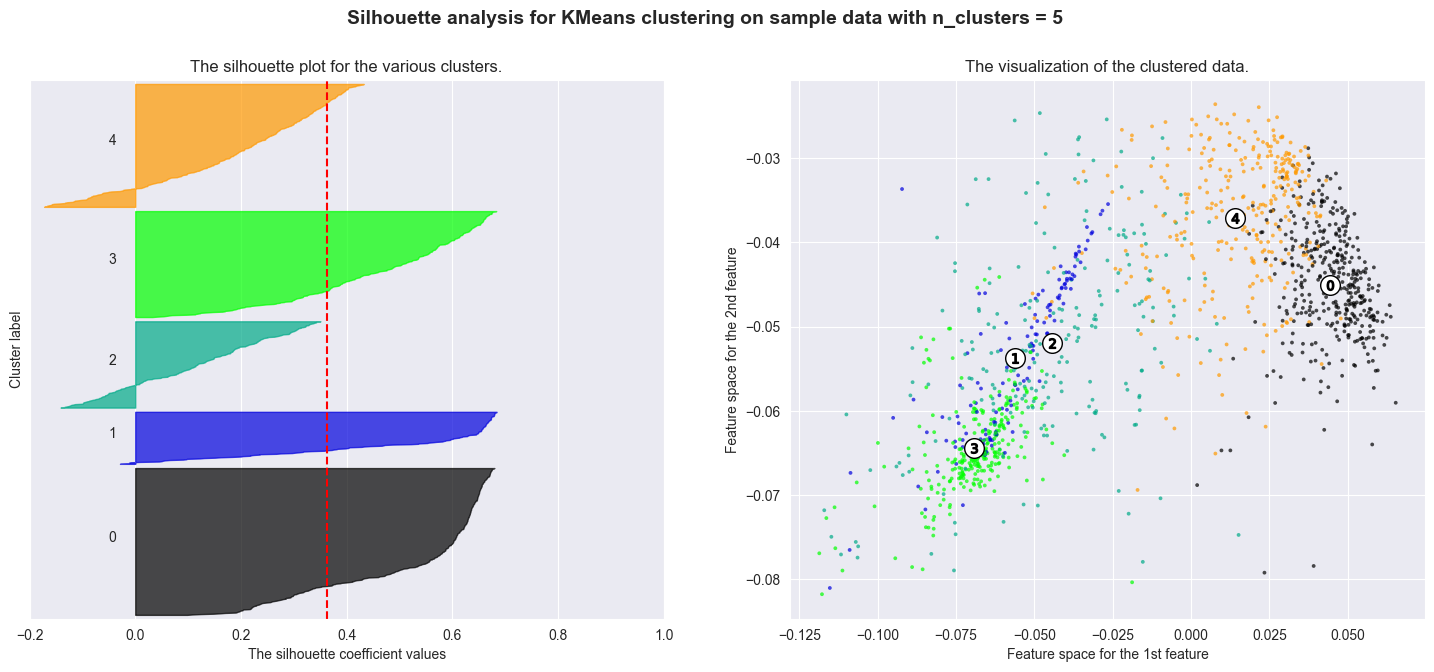

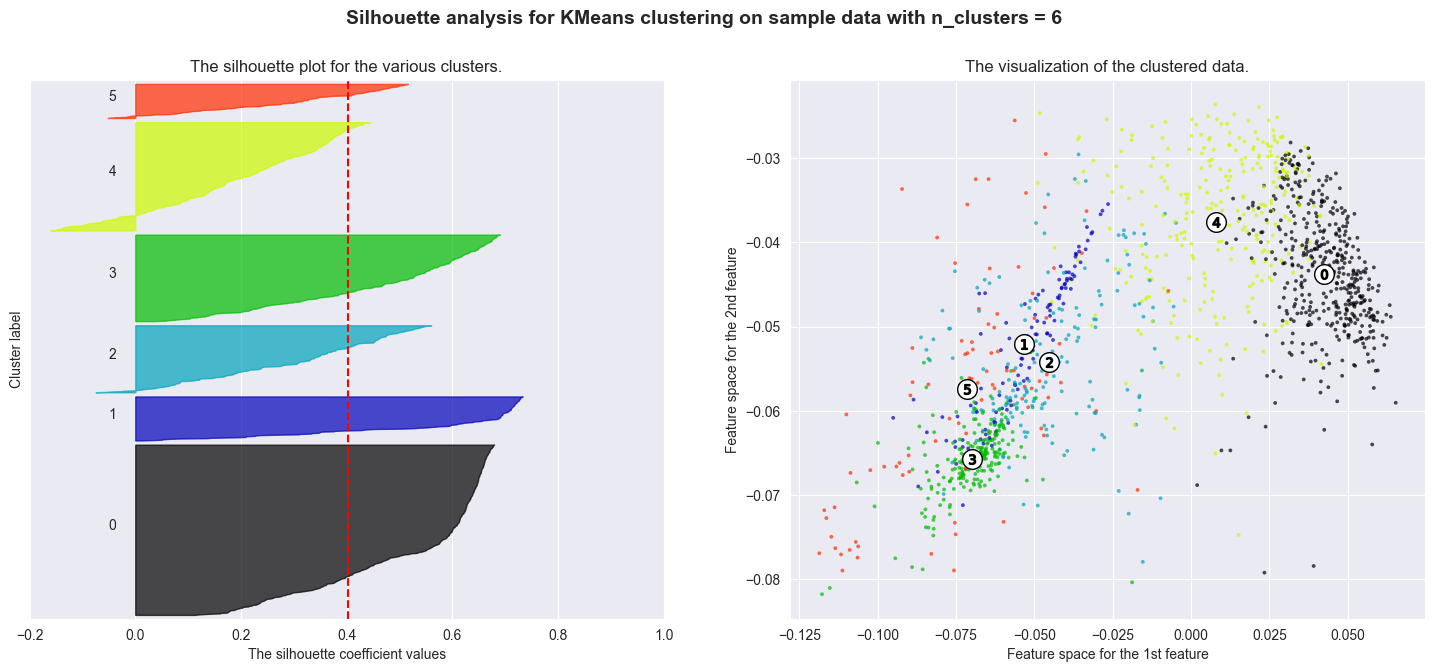

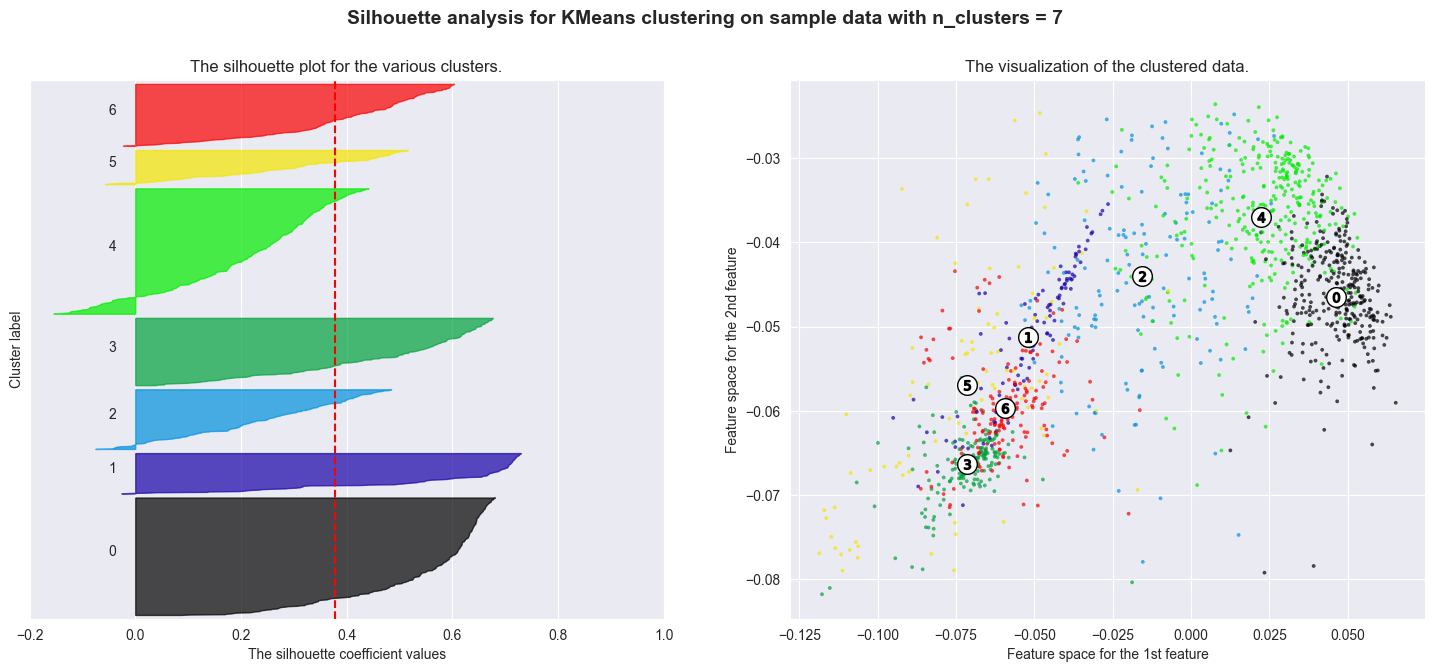

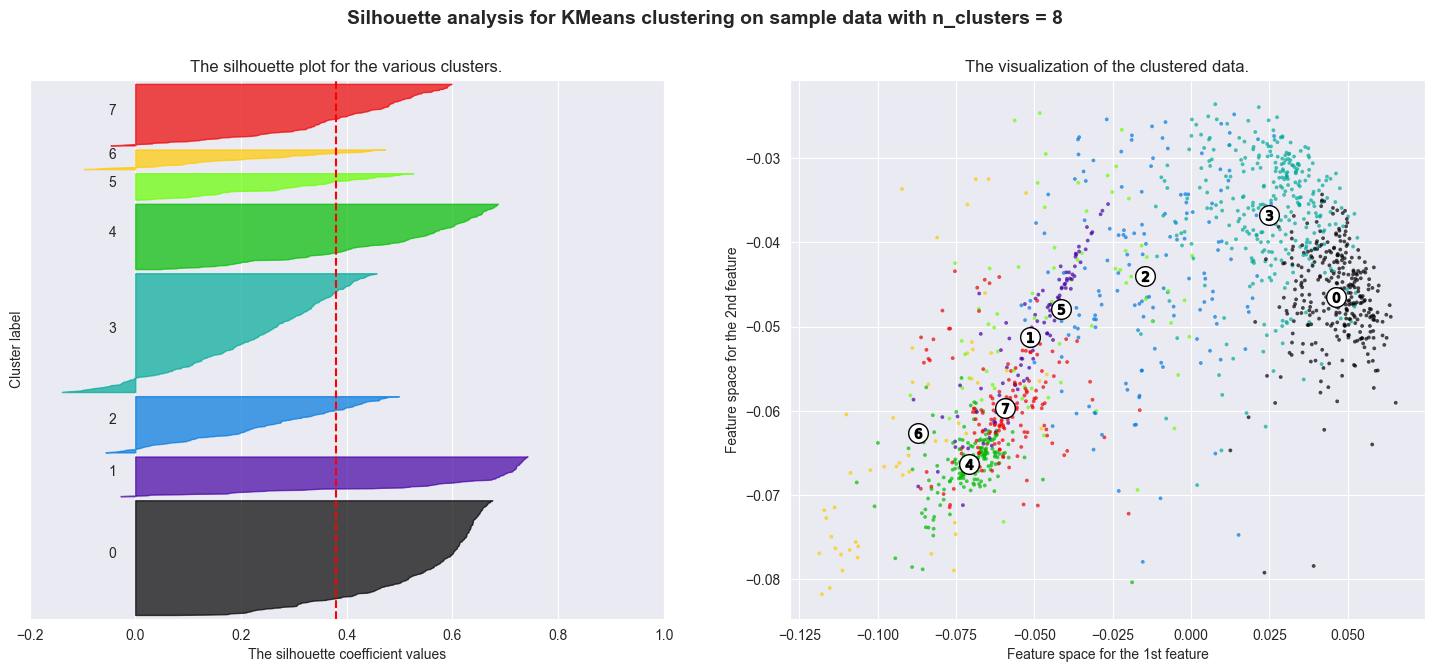

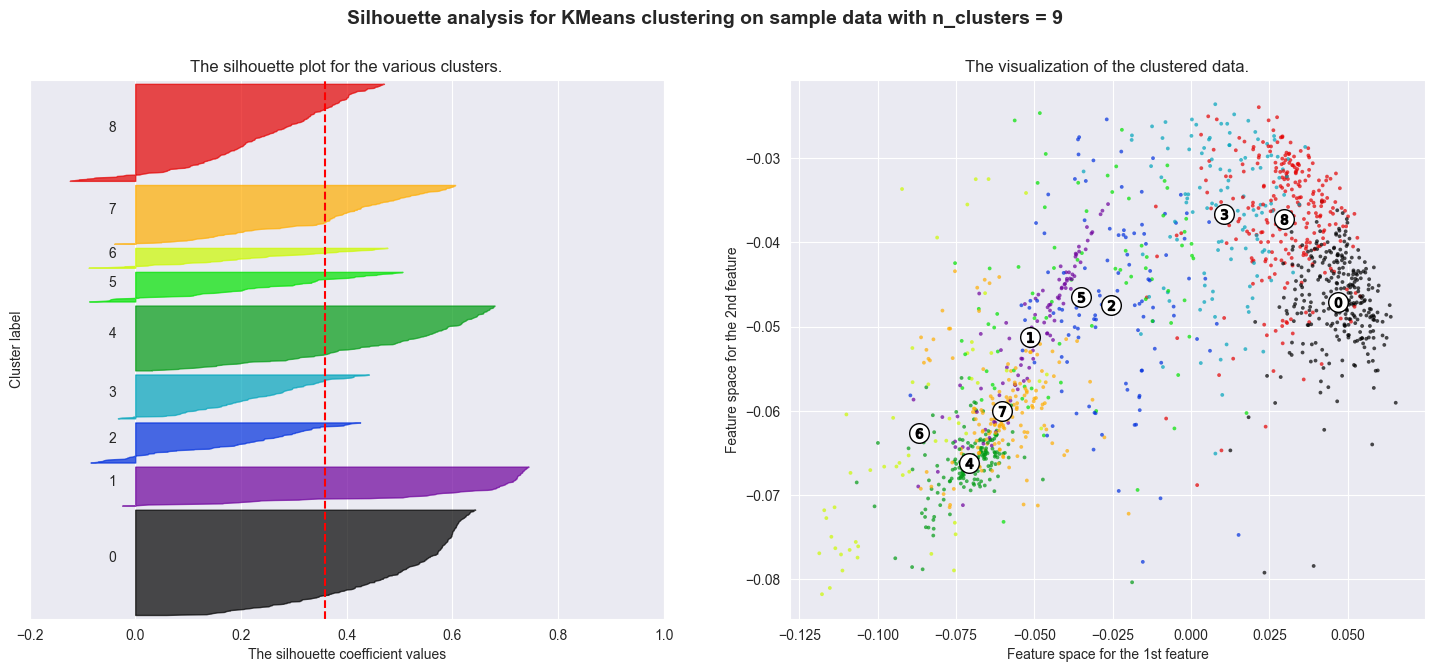

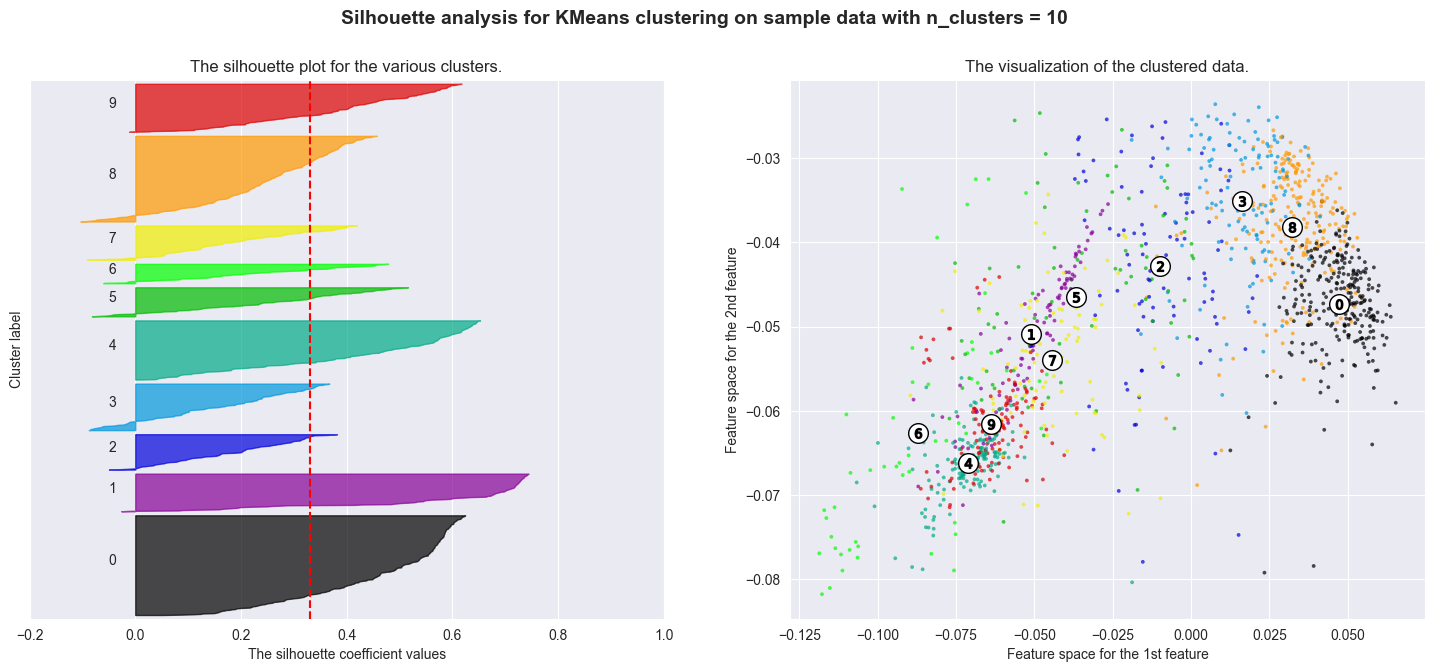

In [77]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(embeddings)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(embeddings, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(embeddings, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        embeddings[:, 0], embeddings[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Homogeneity: 0.068 ± 0.000
Completeness: 0.234 ± 0.000
V-measure: 0.105 ± 0.000
Adjusted Rand-Index: 0.050 ± 0.000
Silhouette Coefficient: 0.542 ± 0.000
Homogeneity: 0.103 ± 0.000
Completeness: 0.230 ± 0.000
V-measure: 0.142 ± 0.000
Adjusted Rand-Index: 0.066 ± 0.000
Silhouette Coefficient: 0.472 ± 0.000
Homogeneity: 0.133 ± 0.000
Completeness: 0.238 ± 0.000
V-measure: 0.171 ± 0.000
Adjusted Rand-Index: 0.074 ± 0.000
Silhouette Coefficient: 0.438 ± 0.000
Homogeneity: 0.138 ± 0.000
Completeness: 0.204 ± 0.000
V-measure: 0.165 ± 0.000
Adjusted Rand-Index: 0.078 ± 0.000
Silhouette Coefficient: 0.362 ± 0.000
Homogeneity: 0.153 ± 0.000
Completeness: 0.213 ± 0.000
V-measure: 0.178 ± 0.000
Adjusted Rand-Index: 0.079 ± 0.000
Silhouette Coefficient: 0.402 ± 0.000
Homogeneity: 0.178 ± 0.000
Completeness: 0.222 ± 0.000
V-measure: 0.198 ± 0.000
Adjusted Rand-Index: 0.087 ± 0.000
Silhouette Coefficient: 0.379 ± 0.000
Homogeneity: 0.186 ± 0.000
Completeness: 0.222 ± 0.000
V-measure: 0.202 ± 0.000
Ad

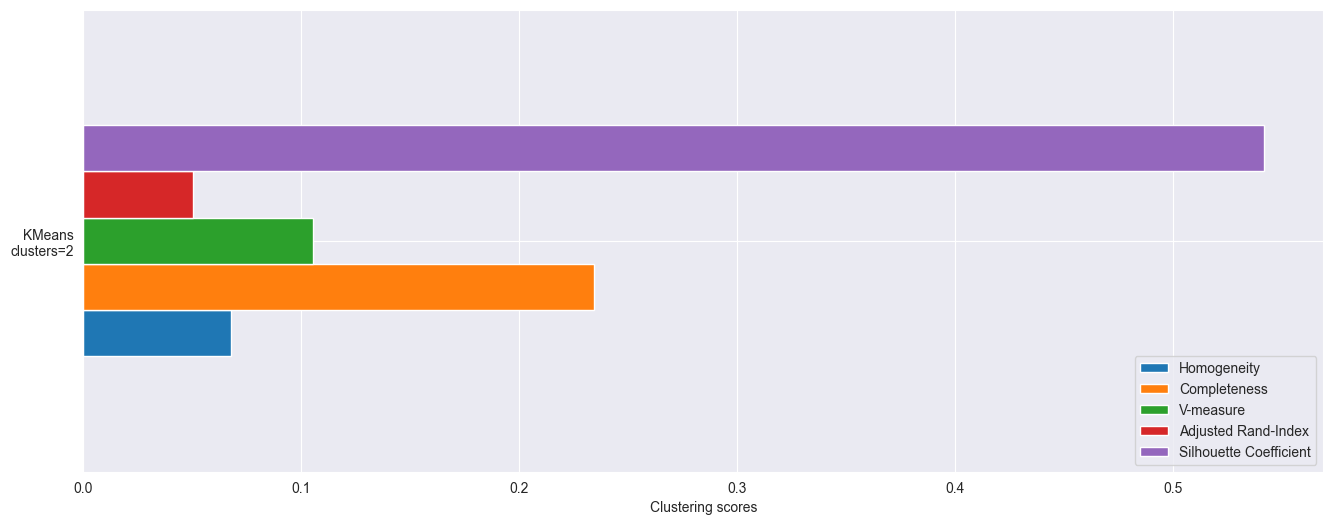

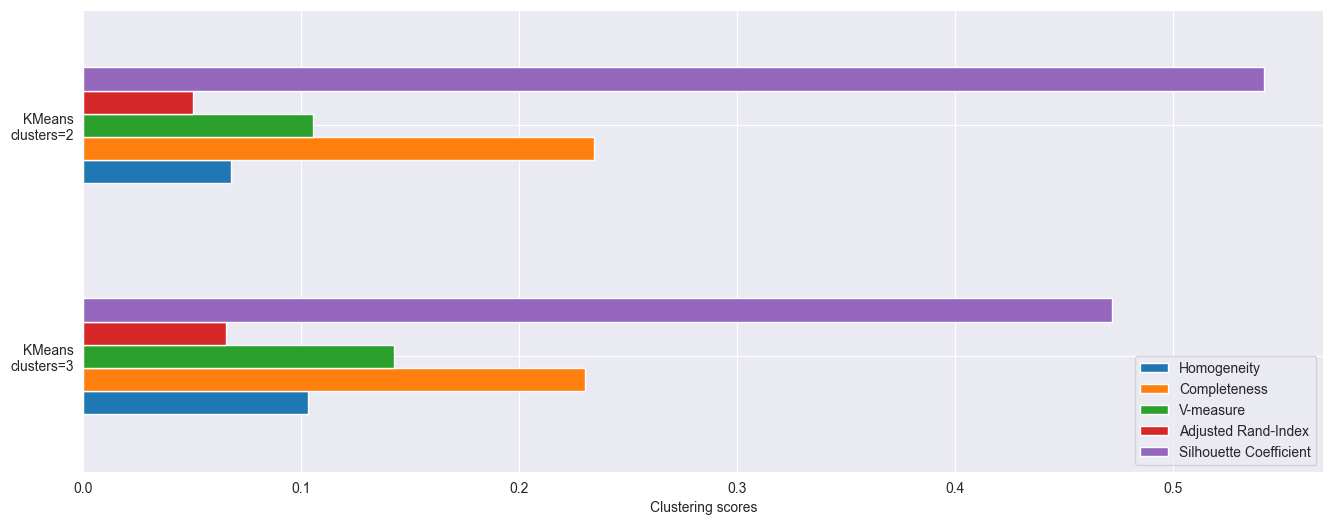

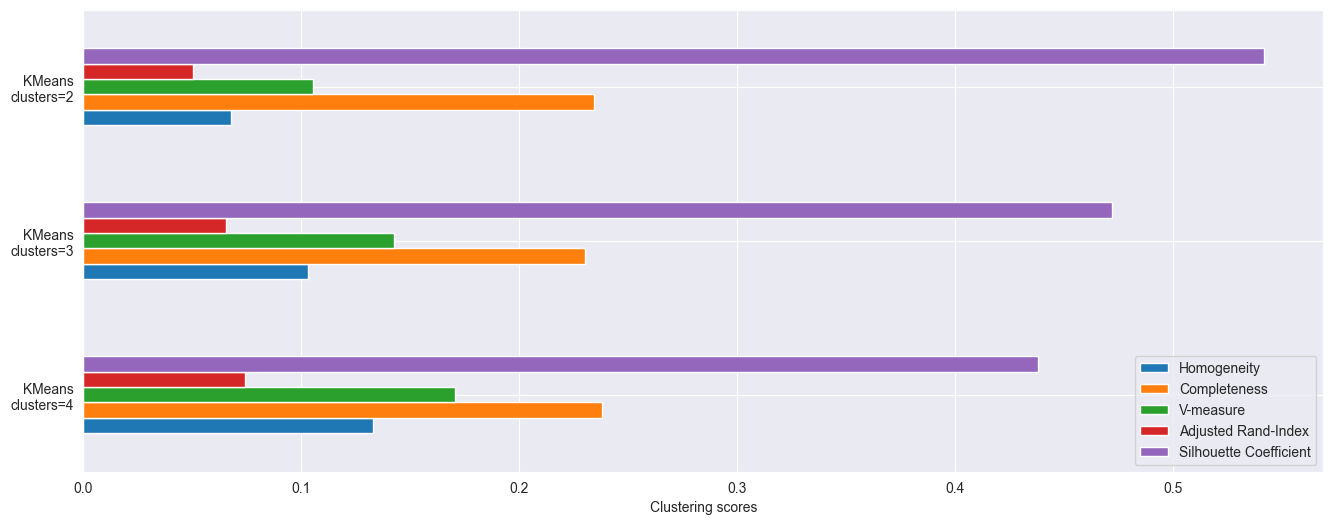

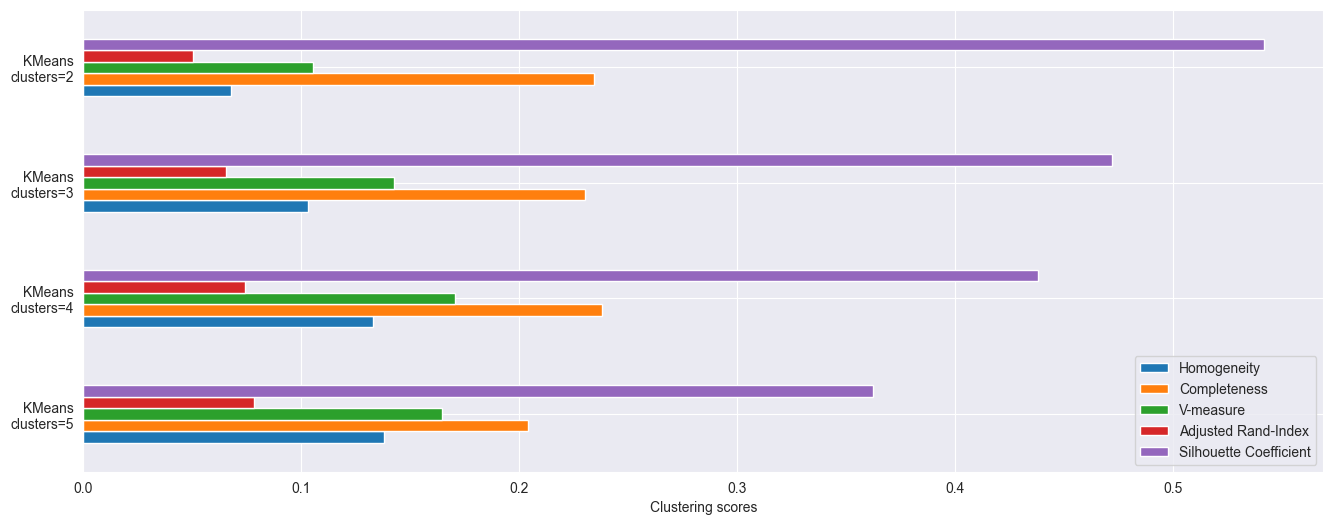

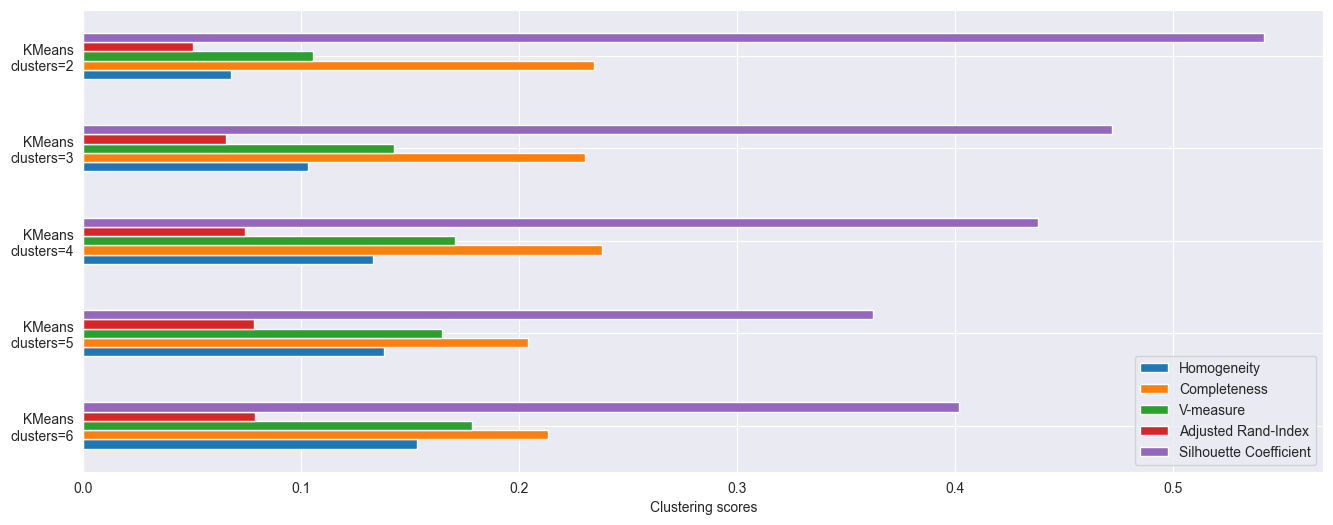

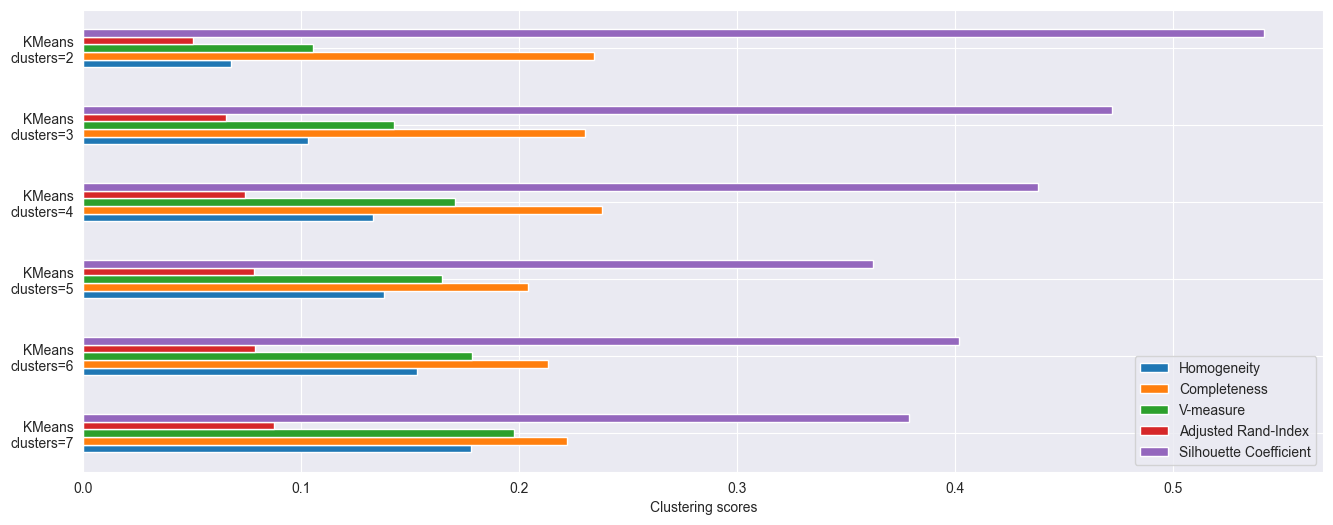

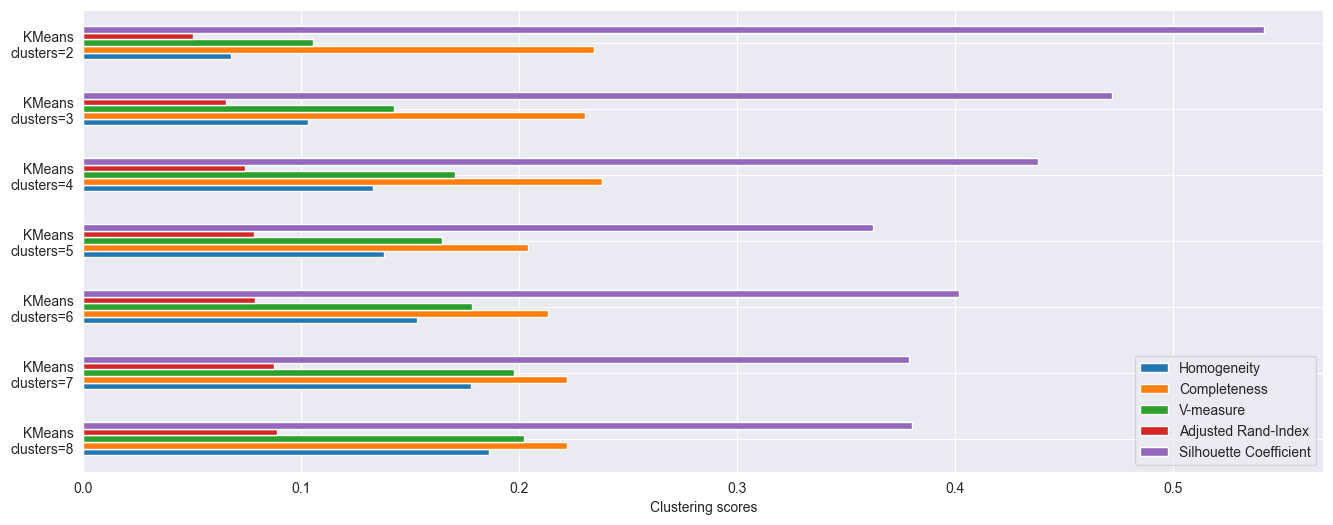

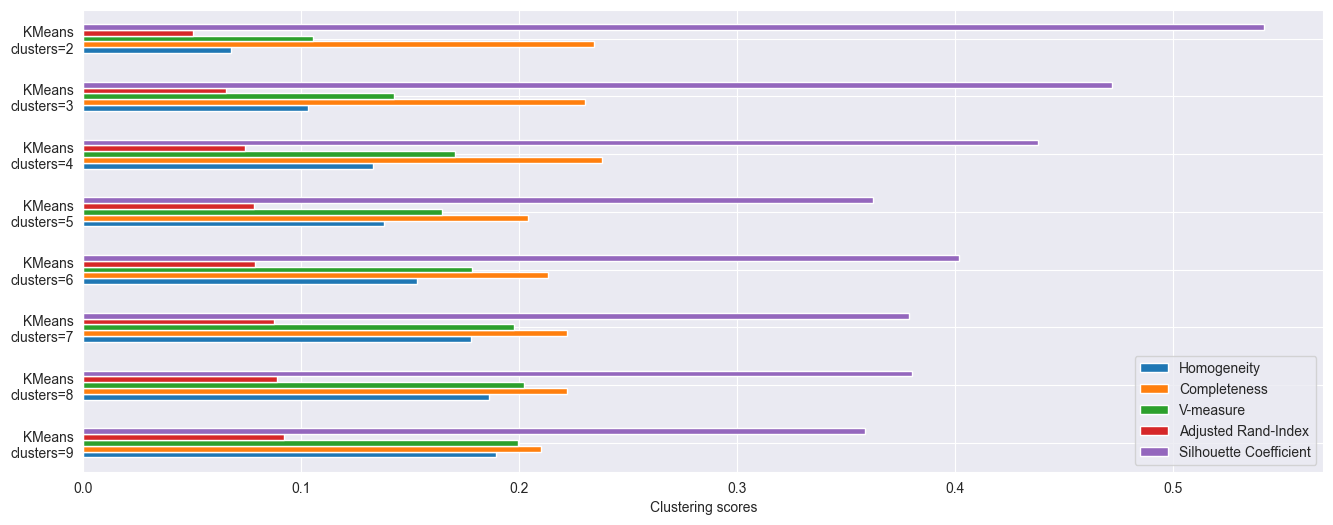

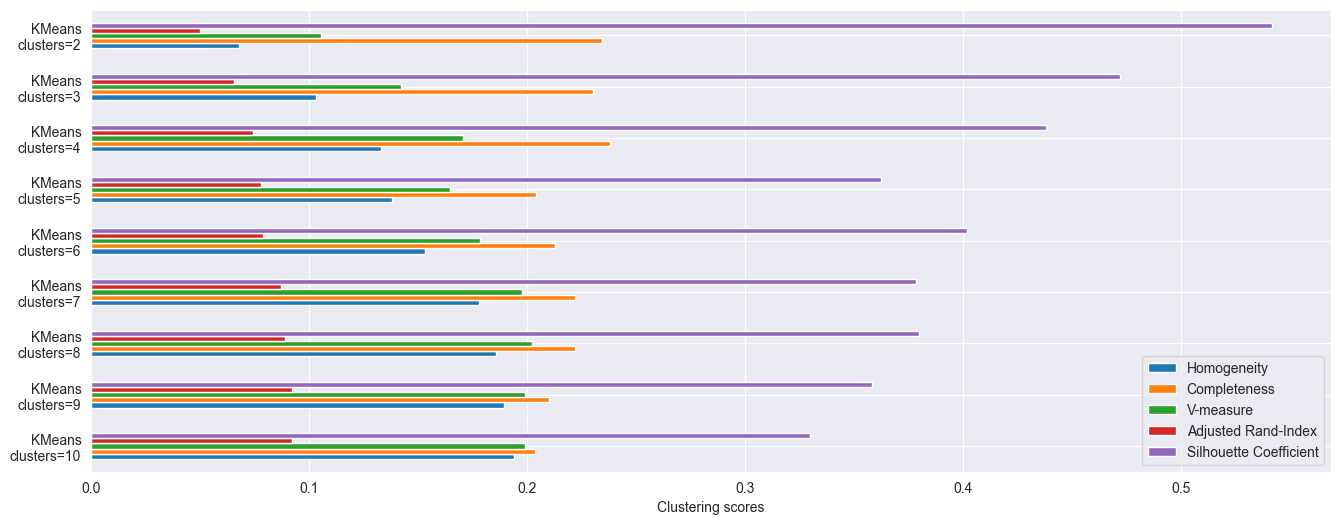

In [70]:
evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, n_clusters, n_runs=5):
    name = km.__class__.__name__ + f'\nclusters={n_clusters}'
    
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=10)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(y, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(y, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(y, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(y, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )

    evaluation = {
        "estimator": name,
    }
    evaluation_std = {
        "estimator": name,
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)
        
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)

    fit_and_evaluate(kmeans, embeddings, n_clusters)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
    df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
    
    df.plot.barh(ax=ax, xerr=df_std)
    ax.set_xlabel("Clustering scores")
    ax.set_ylabel("")
    
plt.show()

Text(0.5, 1.0, 'Elbow curve')

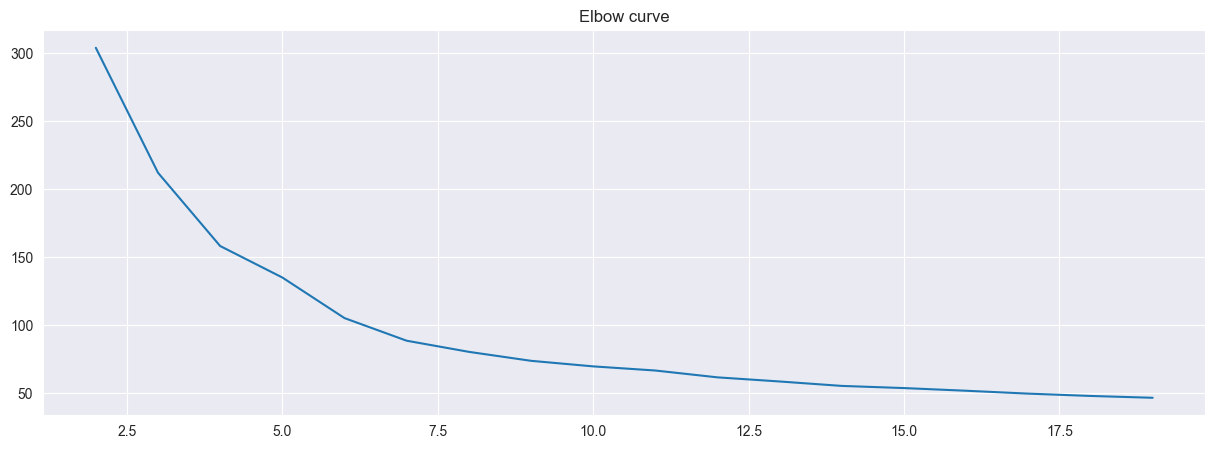

In [73]:
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(embeddings)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')